# Northern boundary sensitivity experiment for the transpolar drift inflow

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import cmocean
import pickle
import xarray as xr

%matplotlib inline

#### Parameters

In [14]:
# experiment year to look at:
year  = 2005

# domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799

# Boundary coordinates:
N_coordinates = ((2168, 2178, 201, 798))
E_coordinates = ((1481, 2178, 778, 798))
S_coordinates = ((1482, 1492, 181, 798))

land_color = '#a9a7a2'

# results to plot:
folder_ref = f'/data/brogalla/run_storage/Mn-reference-202204/'
folder_TPD = f'/data/brogalla/run_storage/Mn-TPD-202204/'

#### Load files

In [15]:
model_ref    = nc.Dataset(f'{folder_ref}ANHA12_ref-spin-up0_20220422/ANHA12_EXH006_5d_20020101_20021231_ptrc_T_20020101-20020105.nc')
lon_model    = np.array(model_ref.variables['nav_lon'])
lat_model    = np.array(model_ref.variables['nav_lat'])
depths_model = np.array(model_ref.variables['deptht'])

In [16]:
mask      = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask     = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 
e1t_base  = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base  = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t       = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), e3t)
nav_lev   = np.array(mask.variables['nav_lev'])
lons      = np.array(mask.variables['nav_lon'])

e1t       = np.tile(e1t_base, (50,1,1))
e2t       = np.tile(e2t_base, (50,1,1))
volume    = e1t*e2t*e3t
area_base = e1t_base*e2t_base
volume_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), volume)
area_masked   = np.ma.masked_where((tmask[0,:,:] < 0.1), area_base)

In [17]:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
ANHA12_lon = np.array(mesh.variables['nav_lon'])
ANHA12_lat = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])
tmask      = np.array(mesh.variables['tmask'])
land_mask  = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

In [18]:
# Mn model run results:
fref  = xr.open_dataset(f'{folder_ref}ANHA12_ref-{year}_20220422/ANHA12_EXH006_{year}_monthly.nc')
fTPD  = xr.open_dataset(f'{folder_TPD}ANHA12_TPD-{year}_20220422/ANHA12_EXH006_{year}_monthly.nc')
dMn_ref = fref['dissolmn'].values[:,0,:,:,:]*1e9
dMn_TPD = fTPD['dissolmn'].values[:,0,:,:,:]*1e9

#### Functions

In [19]:
def plot_slice(mn_model_ref, mn_model_exp, vmax1=10, vmax2=2, vmax2_step=0.5, savefig=False):
    
#     fig, ax, proj = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/AO-map-nobg.pickle','rb'))
    fig, ax1, ax2, ax3, proj = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/diff-panels.pickle','rb'))

    # Plot model background field:
    ax1.set_title('Reference', fontsize=7)
    ax2.set_title('Transpolar drift experiment', fontsize=7)
    ax3.set_title('Difference between transpolar drift experiment and reference', fontsize=7)
    x_model, y_model = proj(lon_model, lat_model)
    CS1 = proj.pcolormesh(x_model, y_model, mn_model_ref, vmin=0, vmax=vmax1, cmap=cmocean.cm.dense, zorder=2, ax=ax1) #ref
    CS2 = proj.pcolormesh(x_model, y_model, mn_model_exp, vmin=0, vmax=vmax1, cmap=cmocean.cm.dense, zorder=2, ax=ax2) #exp
    CS3 = proj.pcolormesh(x_model, y_model, mn_model_exp-mn_model_ref, \
                          vmin=-vmax2, vmax=vmax2, cmap=cmocean.cm.balance, zorder=2, ax=ax3) #difference
    
    for axis in [ax1, ax2, ax3]:
        # add bathymetry contours:
        x, y = proj(ANHA12_lon, ANHA12_lat)
        proj.contour(x, y, mesh_bathy, levels=[1000,2000,3000], linewidths=0.2, colors='k', zorder=3, ax=axis)
        proj.drawcoastlines(color='#373736', linewidth=1.0, ax=axis)
        proj.plot(x[E_coordinates[0]+150:E_coordinates[1],E_coordinates[2]], \
                  y[E_coordinates[0]+150:E_coordinates[1],E_coordinates[2]], 'w--', lw=0.9, zorder=4)
        
    cbar_ax1 = fig.add_axes([0.214, 0.663, 0.01, 0.09])
    cbar_ax2 = fig.add_axes([0.545, 0.663, 0.01, 0.09])
    cbar_ax3 = fig.add_axes([0.214, 0.133, 0.02, 0.16])
    
    # Colorbar:
    CBar1 = plt.colorbar(CS1, cax=cbar_ax1, ticks=np.arange(0, vmax1+2, 2))
    CBar2 = plt.colorbar(CS2, cax=cbar_ax2, ticks=np.arange(0, vmax1+2, 2))
    CBar3 = plt.colorbar(CS3, cax=cbar_ax3, ticks=np.arange(-vmax2-1, vmax2+1, vmax2_step))    
    
    for CBar in [CBar1, CBar2, CBar3]:
        CBar.ax.tick_params(labelsize=5) 
        CBar.set_label('dMn [nM]', fontsize=5)
        
    CBar3.ax.tick_params(labelsize=7) 
    CBar3.set_label('dMn change [nM]', fontsize=7)
    
    fig.text(0.21, 0.89, 'a)', fontsize=8);
    fig.text(0.54, 0.89, 'b)', fontsize=8);
    fig.text(0.21, 0.62, 'c)', fontsize=8);
    
    if savefig:
        fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/S4-TPD.jpg', bbox_inches='tight', dpi=300)
    return

In [20]:
def calculate_depth_weighted(dMn, levels=(0,16)):
    
    dMn_weighted     = dMn[levels[0]:levels[1],:,:]*e3t[levels[0]:levels[1],:,:]
    
    # bottom depth (in case of regions shallower than levels[1]: 
    depth_bottom     = np.copy(mesh_bathy[imin:imax,jmin:jmax])
    depth_bottom[depth_bottom > depths_model[levels[1]-1]] = depths_model[levels[1]-1]
                 
    # calculate average:
    dMn_weighted_ave = np.sum(dMn_weighted, axis=0) / depth_bottom
    
    return dMn_weighted_ave

#### Figures

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


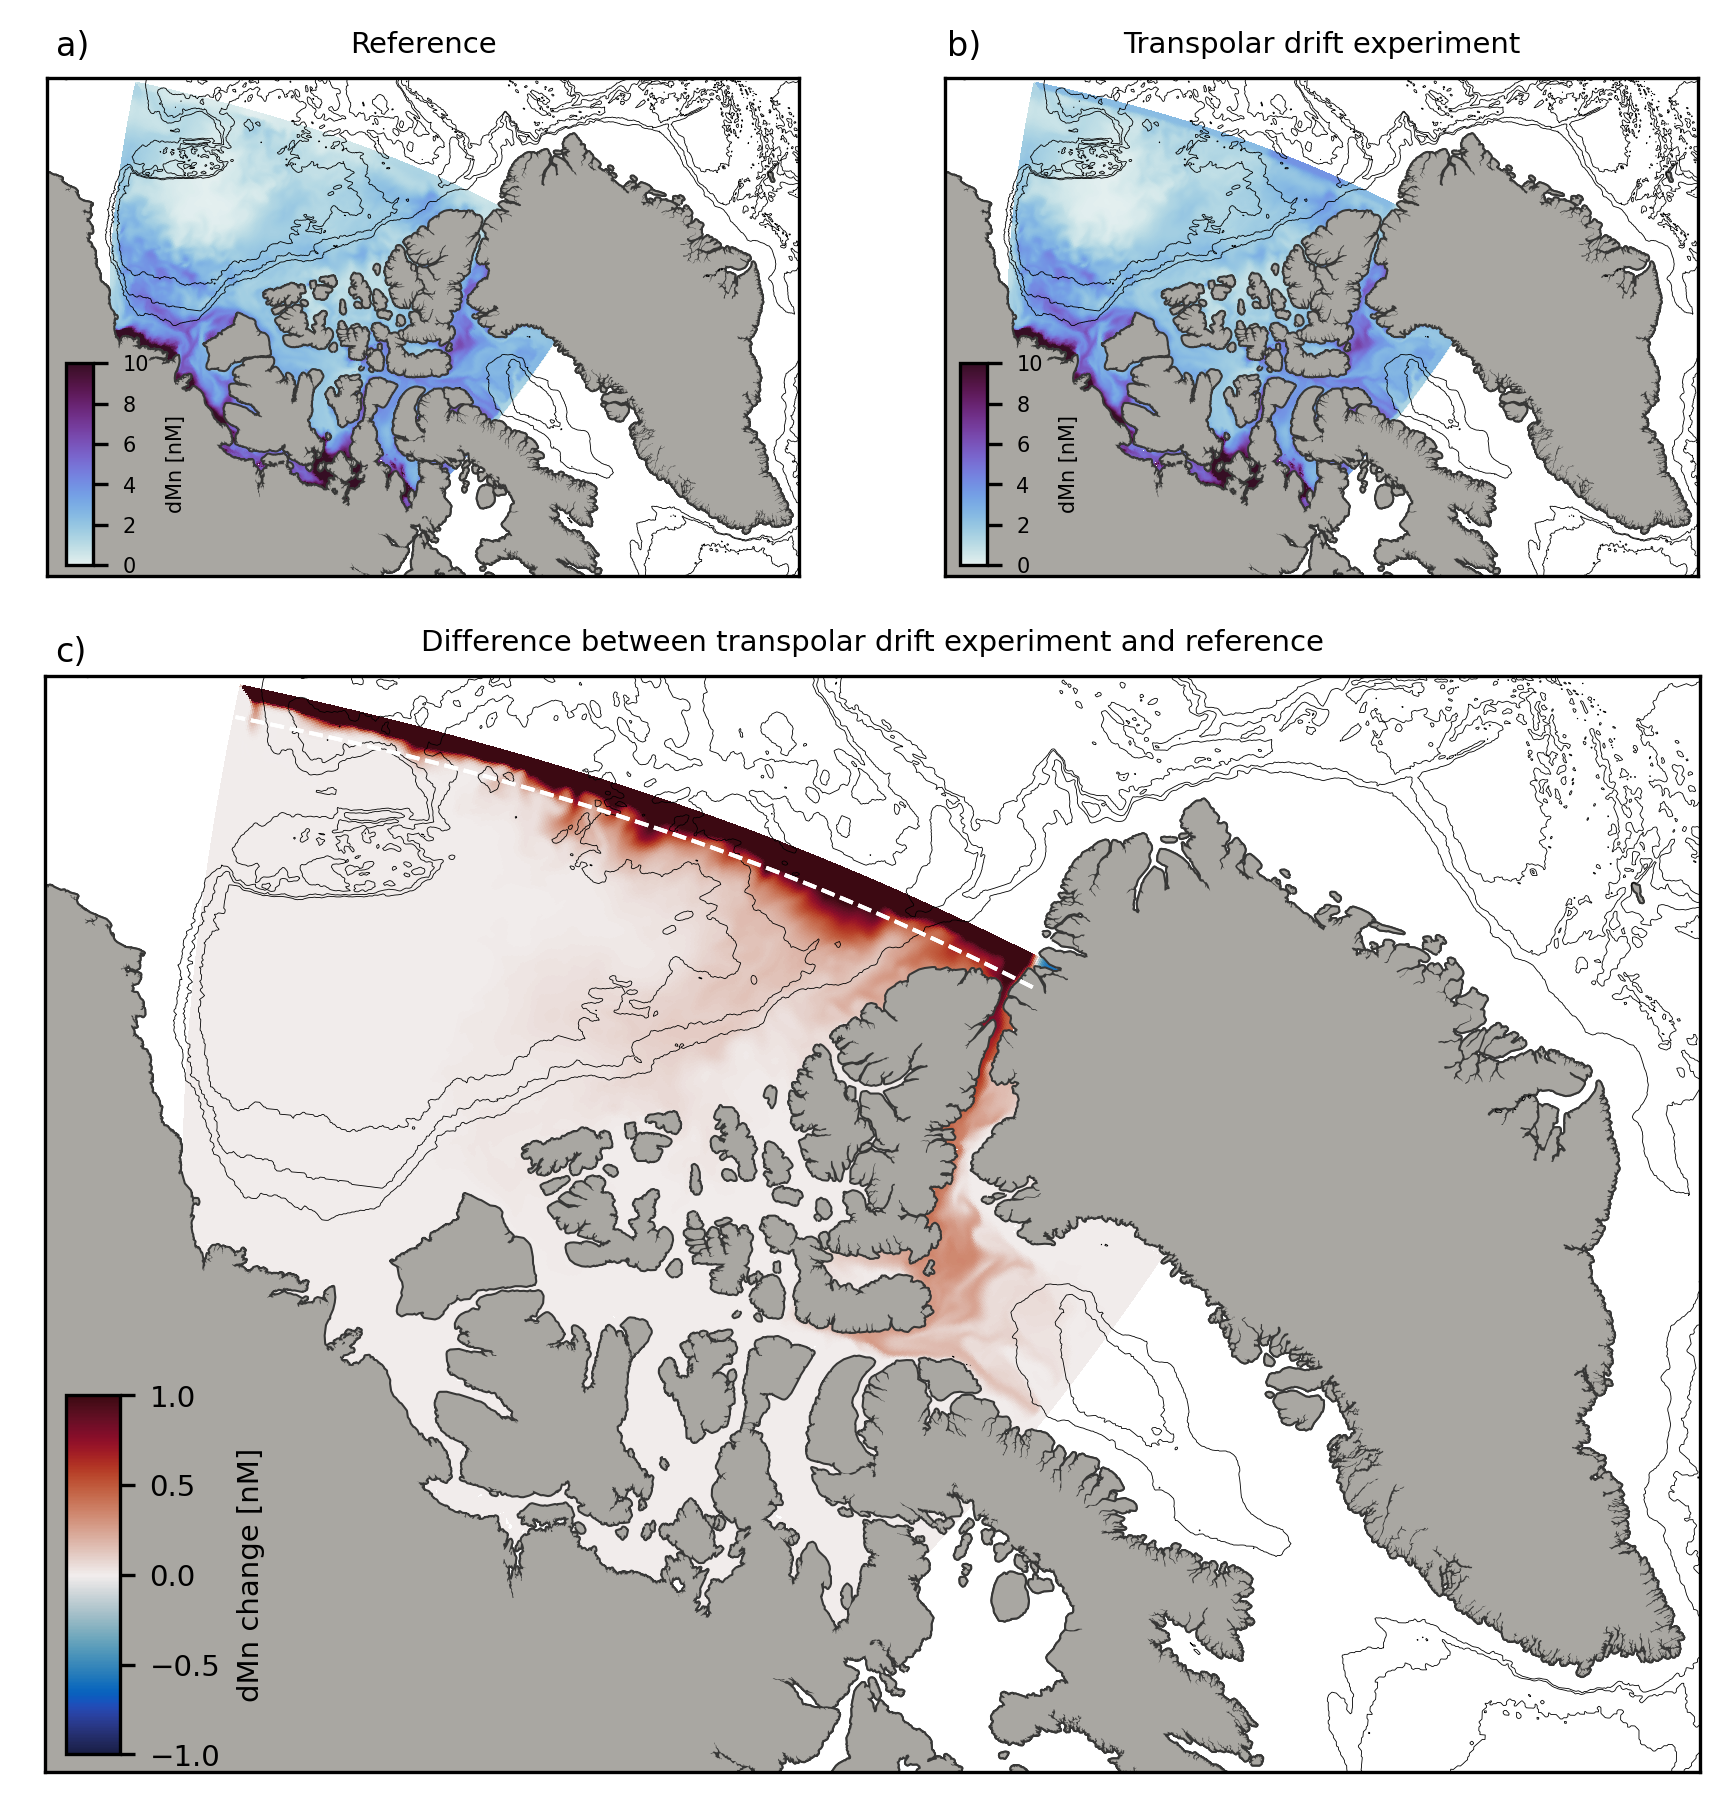

In [26]:
month=8
mn_model_ref = calculate_depth_weighted(dMn_ref[month,:,:,:])
mn_model_exp = calculate_depth_weighted(dMn_TPD[month,:,:,:])
plot_slice(mn_model_ref, mn_model_exp, vmax1=10, vmax2=1, vmax2_step=0.5, savefig=False)